# get data

In [ ]:
%%sh
# aws s3 cp s3://prabhat-ml/abalone-multivariate/ . --recursive
wget --quiet https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data
wget --quiet https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.names

# analyze data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [2]:
df = pd.read_csv("abalone.data", 
                 names=['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Age'])

In [3]:
df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


### exlude target column Age

In [4]:
df_y = df.iloc[:,8:]
df_x = df.iloc[:,0:8]
df_x.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


In [5]:
df_y.head()

,Age
0,15
1,7
2,9
3,10
4,7


### one-hot-encode Sex field

In [6]:
x = pd.get_dummies(df_x, ['Sex'])

In [7]:
x.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Sex_F,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0,1,0


In [32]:
idx =5
x[idx-1:idx]

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Sex_F,Sex_I,Sex_M
4,0.33,0.255,0.08,0.205,0.0895,0.0395,0.055,0,1,0


In [31]:
x[0:2]

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Sex_F,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,0,0,1


### normalize Age column

In [8]:
df_y.max()

Age    29
dtype: int64

In [9]:
y = pd.DataFrame()
y['Age'] = df_y['Age']/df_y['Age'].max()

In [10]:
y.head()

,Age
0,0.517241
1,0.241379
2,0.310345
3,0.344828
4,0.241379


In [11]:
train_percent = .95
test_percent = 1 - train_percent

x_train = x[:round(len(x)*train_percent)] 
x_test = x[round(len(x)*train_percent):] 

y_train = y[:round(len(y)*train_percent)] 
y_test = y[round(len(y)*train_percent):]  

print(len(x_train), len(x_test))

3968 209


In [12]:
X = torch.tensor(x_train.to_numpy()).float()
Y = torch.tensor(y_train.to_numpy()).float()

X_test = torch.tensor(x_test.to_numpy())
Y_test = torch.tensor(y_test.to_numpy())

In [13]:
X.size()

torch.Size([3968, 10])

In [14]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10, 144)
        self.fc2 = nn.Linear(144, 72)
        self.fc3 = nn.Linear(72, 18)
        self.fc4 = nn.Linear(18, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        return x        

### set hyperparameters

In [15]:
device = torch.device("cuda")
epochs = 50000
criterion = nn.MSELoss()
learning_rate = .01
# batch_size = 30
print_interval = round(epochs/10)

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
X = X.to(device)
Y = Y.to(device)

## train

In [16]:
%time

losses = []

model.train()  

for epoch in range(epochs):    
    optimizer.zero_grad()
    
    yHat = model(X)
    loss = criterion(yHat,Y)
    
    losses.append(loss.item())
    
    if epoch % print_interval == 0:
        print('epoch: ', epoch, ', loss: ', loss.item())
    
    loss.backward()
    
#     for param in model.parameters():
#         print(param.grad.data.sum())

#     # start debugger
#     import pdb; pdb.set_trace()
    
    optimizer.step()
    
    # validation
#     model.eval()
    
    

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 7.39 µs
epoch:  0 , loss:  0.04526463896036148
epoch:  5000 , loss:  0.0025322067085653543
epoch:  10000 , loss:  0.0017603558953851461
epoch:  15000 , loss:  0.001418204396031797
epoch:  20000 , loss:  0.0014208348002284765
epoch:  25000 , loss:  0.0012823832221329212
epoch:  30000 , loss:  0.0012011288199573755
epoch:  35000 , loss:  0.0017688550287857652
epoch:  40000 , loss:  0.0011842261301353574
epoch:  45000 , loss:  0.0010463485959917307


Text(0, 0.5, 'loss')

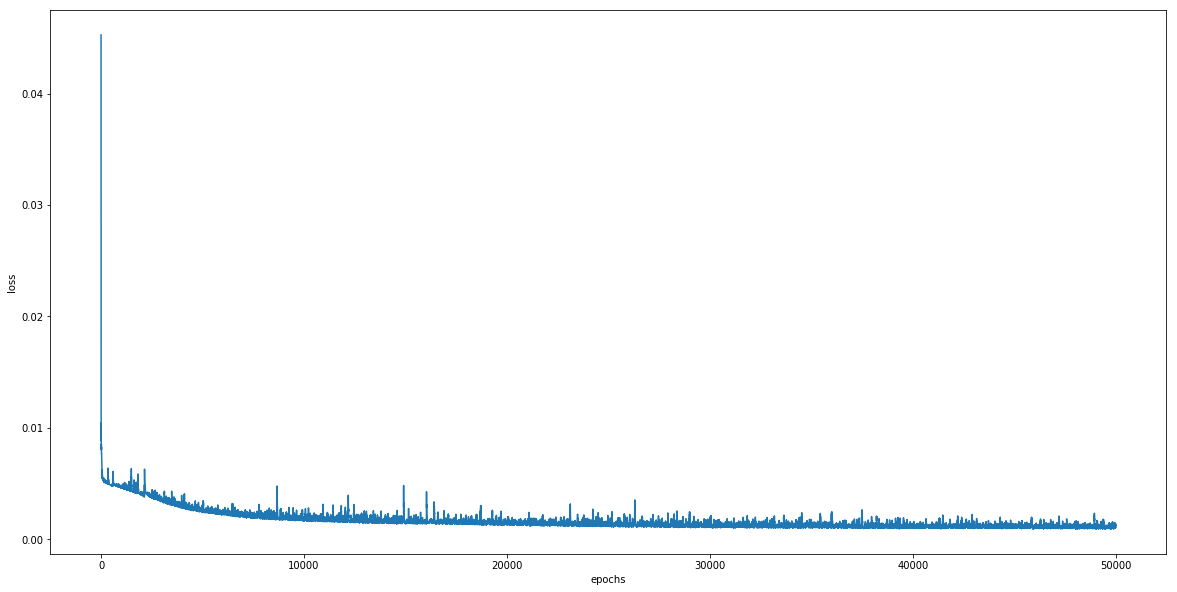

In [17]:
plt.figure(figsize=(20,10))
plt.plot(range(epochs), losses)
plt.xlabel('epochs')
plt.ylabel('loss')

In [18]:
losses[0]

0.04526463896036148

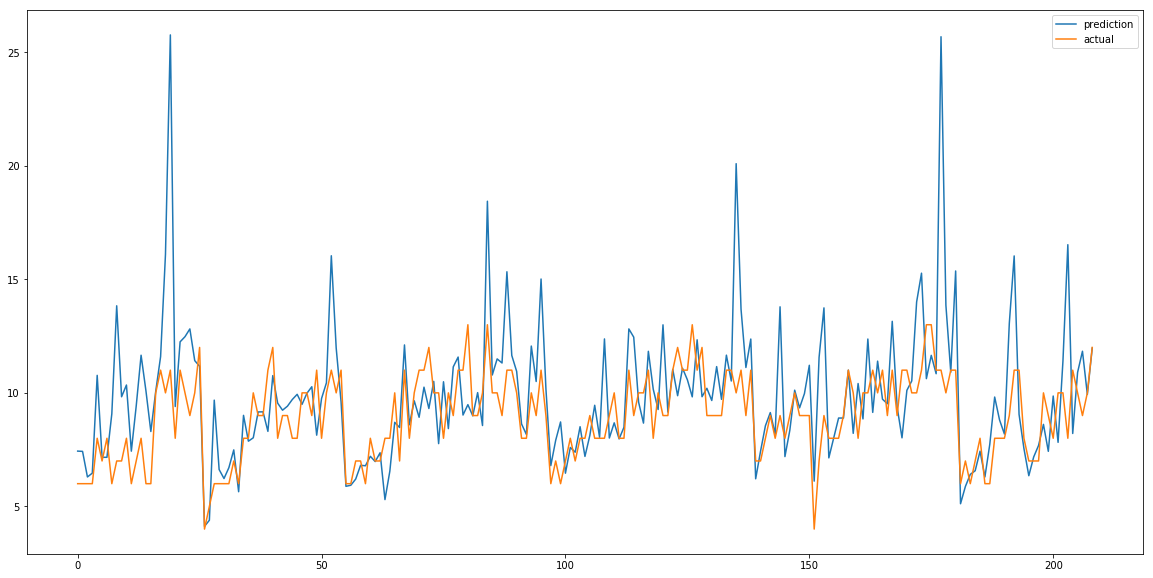

In [19]:
model.eval()
with torch.no_grad():
    yPred = model(X_test.to(device).float())
    plt.figure(figsize=(20,10))
    plt.plot((yPred*29).cpu(), label='prediction')
    plt.plot((Y_test*29).cpu(), label='actual')
    plt.legend()
    